In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

from collections import Counter

pd.set_option('display.max_columns', None)

plt.rc('font',family = 'serif')

colors_ = sns.color_palette('viridis', 20)

coeffs = ['IP', 'BT', 'NEL', 'PLTH', 'RGEO', 'KAREA', 'EPS', 'MEFF']

path = "../data/"
fig_path = "../../../LATEX/Latex Images/"

In [2]:
class MyCounter(Counter):
    def __str__(self):
        return "\n".join('{}: {}'.format(k, v) for k, v in sorted(self.items()))
    
class HUEOrder:
    def __init__(self, hue_order):
        self.hue_order = hue_order

    def get_values(self, key, subkeys):
        result = {}
        subdict = self.hue_order.get(key, {})
        for subkey in subkeys:
            result[subkey] = subdict[subkey]
        return result



# <center>Cornerstone for Interpretation | Physical Particles</center>

**NORMALIZED ION GYRORADIUS**

$$
    \rho_* = \frac{\rho_i}{a} \propto (M_{eff}T)^{1/2}B_t^{-1}
$$

**NORMALIZED PLASMA PRESSURE**

$$
    \beta_t = \frac{2\mu_0 p}{B_t^2} \propto nTB_t^{-2}
$$

**NORMALIZED ION COLLISION FREQUENCY**

$$
    \nu_* = \nu_{ii}\left(\frac{m_i}{eT}\right)^{1/2}\left(\frac{R_{geo}}{a}\right)^{3/2}q_{cyl}R_{geo}
$$

**SAFETY FACTOR -- CYLINDRICAL APPROXIMATION**

$$
    q_{cyl} = \frac{2\pi a^2 \kappa_a B_t}{\mu_0 R_{geo}I_P}
$$

Where $p,n$ [m^{-3}] and $T$ [eV] are the volume-averaged pressure, density and temperature; respectively. 



**GYRO REDUCED BOHM ENERGY CONFINEMENT TIME | DIFFUSIVITY**

[Following is an answer from ChatGPT](https://chat.openai.com)

In the field of plasma physics and fusion research, the Bohm-normalized diffusivity refers to a characteristic parameter that quantifies the transport of heat or particles in a tokamak, which is a type of magnetic confinement fusion device. It is named after physicist David Bohm, who made significant contributions to the study of plasma physics.

The Bohm-normalized diffusivity, often denoted as $\chi_{\text{Bohm}}$, is defined as the ratio of the actual diffusivity in the tokamak, denoted as $\chi$, to a reference diffusivity known as the Bohm diffusivity, denoted as $\chi_{\text{B}}$. Mathematically, it is expressed as:

$$
    \chi_{\text{Bohm}} = \frac{\chi}{\chi_{\text{B}}}
$$
 

The Bohm diffusivity is a fundamental parameter that arises from theoretical considerations and is often used as a reference diffusivity in plasma physics. It represents an estimate of the minimal transport that can occur due to the random motion of charged particles in a plasma.

The Bohm-normalized diffusivity is an important parameter in the study of plasma transport in tokamaks, as it provides insights into the efficiency of heat and particle transport in the plasma. A value of $\chi_{\text{Bohm}}$ close to 1 indicates that the actual diffusivity is similar to the Bohm diffusivity, suggesting that transport in the tokamak is close to the minimal level expected from random particle motion. Values of $\chi_{\text{Bohm}}$ significantly different from 1 can indicate the presence of anomalous transport, which is transport that deviates from the expected behavior based on classical physics and is often associated with the presence of turbulence in the plasma. Understanding and controlling plasma transport, including the Bohm-normalized diffusivity, is a key challenge in achieving practical magnetic confinement fusion for future energy production.

In [3]:
physical_var = ["RHOSTAR","BETASTAR","NUSTAR", "Q95", "TAUBOHM"]

In [4]:
group1 = pd.read_csv(path+"id_vs_frequency_decreasing_ds.csv")
group1 = group1[group1.frequency > 0] # otherwise alpha-R ~ 1
group2 = pd.read_csv(path+"IDs/alpha_one/R_ids_alpha_0.9996.csv")
group3 = pd.read_csv(path+"IDs/alpha_two/R_ids_alpha_1.9930.csv")

DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False)
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

DB2 = pd.read_csv(path+"DB2P8.csv")

# There are shots missing in DB5 from DB2P8
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

### Categorical Data | Preprocessing

In [5]:
TOK_characteristics = ["DIVNAME","WALMAT","DIVMAT","LIMMAT"]
categorical = ["PREMAG","HYBRID","CONFIG","ELMTYPE","ECHMODE",
               "ICSCHEME","AUXHEAT","EVAP","PELLET"] + TOK_characteristics 

DB5[categorical] = DB5[categorical].fillna('UNKNOWN')
DB5["DIVNAME"]   = DB5["DIVNAME"].str.replace("NONAME","UNKNOWN",regex=False)


DB5["PELLET"] = DB5["PELLET"].str.replace("GP_D","D",regex=False)
DB5["PELLET"] = DB5["PELLET"].str.replace("GP_H","H",regex=False)

DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("CC","C",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI1","TI12",regex=False)
DB5["DIVMAT"] = DB5["DIVMAT"].str.replace("TI2","TI12",regex=False)

DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-I)|(DV-IPRE)|(DV-IPOST)",
                                            "DV-I",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(DIV-II)|(DV-IIc)|(DV-II-C)|(DV-IIb)|(DV-IIc)|(DV-IId)|(DV-IId)",
                                            "DV-II",regex=True)
DB5["DIVNAME"] = DB5["DIVNAME"].str.replace("(MARK0)|(MARKI)|(MARKIIA)|(MARKGB)|(MARKGBSR)|"+
                                            "(MARKIA)|(MARKIAP)|(MARKSR)|(MARKA)|(MARKP)",
                                            "MARK",regex=True)

DB5["ICSCHEME"]   = DB5["ICSCHEME"].str.replace("OFF","NONE",regex=False)

DB5["EVAP"] = DB5["EVAP"].str.replace("CARBH","C-H",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("CARB","C",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("BOROC","C-BO",regex=True)
DB5["EVAP"] = DB5["EVAP"].str.replace("(BOROA)|(BOROB)|(BOROX)|(BOR)","BO",regex=True)
#DB5["EVAP"] = DB5["EVAP"].str.replace("DECABOA","C",regex=True)

### Making sure datas represent correct alpha-R

In [6]:
data1 = DB5[ DB5.id.isin(group1.id.values)] # alpha_R -- 0.6558 --> when considering DB2 for calculation
data2 = DB5[~DB5.id.isin(group1.id.values)] # alpha_R -- 2.1638 --> when considering DB2 for calculation
data2 = data2[~data2.id.isin(DB2.id.values)]# Removing DB2, because most of these shots have missing info

In [7]:
def get_regression(_R, withDB2=False):
    """
    ASSUMING DATA IS ***NOT*** GIVEN IN LOG-SCALE
    """
    if withDB2:
        data = _R.copy()
    else:     
        data = pd.concat([DB2, _R],
                         axis=0, 
                         ignore_index=True
                        )
    Y_ = data[["TAUTH"]].apply(np.log).to_numpy()
    # Adding a column for the intercept
    _df = data[coeffs].apply(np.abs).apply(np.log)
    _df.insert(
        loc = 0, 
        column = "intercept", 
        value = np.ones(len(_df))
    )
    X_ = _df.to_numpy()
    n_, p_ = X_.shape
    model = sm.OLS(Y_,X_)
    regression = model.fit()
    return data, regression, (n_,p_)

d_, r_, np_ = get_regression(data2, withDB2=False)

In [8]:
# Needed for Improved Visualization in Plots

HUE_ORDER = {}

HUE_ORDER["ICSCHEME"] = dict(zip(sorted(data1["ICSCHEME"].unique()), colors_[:len(data1["ICSCHEME"].unique())]))
HUE_ORDER["ELMTYPE"] = dict(zip(sorted(data1["ELMTYPE"].unique()), colors_[:len(data1["ELMTYPE"].unique())]))
HUE_ORDER["HYBRID"] = dict(zip(sorted(data1["HYBRID"].unique()), colors_[:len(data1["HYBRID"].unique())]))
HUE_ORDER["AUXHEAT"] = dict(zip(sorted(data1["AUXHEAT"].unique()), colors_[:len(data1["AUXHEAT"].unique())]))
HUE_ORDER["DIVMAT"] = dict(zip(sorted(data1["DIVMAT"].unique()), colors_[:len(data1["DIVMAT"].unique())]))
HUE_ORDER["WALMAT"] = dict(zip(sorted(data1["WALMAT"].unique()), colors_[:len(data1["WALMAT"].unique())]))
HUE_ORDER["EVAP"] = dict(zip(sorted(data1["EVAP"].unique()), colors_[:len(data1["EVAP"].unique())]))
HUE_ORDER["ECHMODE"] = dict(zip(sorted(data1["ECHMODE"].unique()), colors_[:len(data1["ECHMODE"].unique())]))
HUE_ORDER["PELLET"] = dict(zip(sorted(data1["PELLET"].unique()), colors_[:len(data1["PELLET"].unique())]))
HUE_ORDER["CONFIG"] = dict(zip(sorted(data1["CONFIG"].unique()), colors_[:len(data1["CONFIG"].unique())]))
HUE_ORDER["LIMMAT"] = dict(zip(sorted(data1["LIMMAT"].unique()), colors_[:len(data1["LIMMAT"].unique())]))
HUE_ORDER["TOK"] = dict(zip(sorted(data1["TOK"].unique()), colors_[:len(data1["TOK"].unique())]))

hue_order = HUEOrder(HUE_ORDER)


# <center>General Description per Group</center>

In [9]:
## GROUP 1 -- Decreasing alpha-R the most
print(f"GROUP 1 | size = {len(data1)}")
print(f"Missing Tokamaks: {DB5[~DB5.TOK.isin(data1.TOK.unique())]['TOK'].unique()}")
print(f"Present Tokamaks: {data1.TOK.unique()}")
print("\n")
print(f"ELMTYPE\n{MyCounter(data1['ELMTYPE'])}")
print("\n")
print(f"PHASE\n{MyCounter(data1['PHASE'])}")

GROUP 1 | size = 1486
Missing Tokamaks: ['ASDEX' 'COMPASS' 'JFT2M' 'PBXM' 'PDX' 'TCV' 'TDEV' 'TFTR']
Present Tokamaks: ['AUG' 'AUGW' 'CMOD' 'D3D' 'JET' 'JETILW' 'JT60U' 'MAST' 'NSTX' 'START']


ELMTYPE
TYPE-1+2: 12
TYPE-1+5: 7
TYPE-I: 1023
TYPE-II: 100
TYPE-III: 148
TYPE-RF: 5
TYPE-V: 31
UNKNOWN: 160


PHASE
HGELM: 875
HGELMH: 262
HSELM: 326
HSELMH: 23


In [10]:
## GROUP 2 -- Decreasing alpha-R, but not so much
print(f"GROUP 2 | size = {len(data2)}")
print(f"Missing Tokamaks: {DB5[~DB5.TOK.isin(data2.TOK.unique())]['TOK'].unique()}")
print(f"Present Tokamaks: {data2.TOK.unique()}")
print("\n")
print(f"ELMTYPE\n{MyCounter(data2['ELMTYPE'])}")
print("\n")
print(f"PHASE\n{MyCounter(data2['PHASE'])}")

GROUP 2 | size = 3456
Missing Tokamaks: ['ASDEX' 'PBXM' 'PDX']
Present Tokamaks: ['AUG' 'AUGW' 'CMOD' 'COMPASS' 'D3D' 'JET' 'JETILW' 'JFT2M' 'JT60U' 'MAST'
 'NSTX' 'START' 'TCV' 'TDEV' 'TFTR']


ELMTYPE
TYPE-1+2: 20
TYPE-1+5: 13
TYPE-I: 2685
TYPE-II: 186
TYPE-III: 291
TYPE-RF: 25
TYPE-V: 34
UNKNOWN: 202


PHASE
HGELM: 2012
HGELMH: 615
HSELM: 774
HSELMH: 55


In [11]:
sorted(data1["DATE"])[0], sorted(data1["DATE"])[-1]

(19900716, 20171026)

In [12]:
sorted(data2["DATE"])[0], sorted(data2["DATE"])[-1]

(19890623, 20171026)

# <center>General Analysis</center>

In [13]:
RF_features = [
    'WFFORM', 'QCYL5', 'ENBI', 'POHM', 'WALMAT', 'WMHD', 'PRAD',
    'LHTIME', 'PELLET', 'ZEFF', 'PFLOSS', 'PLTH', 'EVAP',
    'NESOL', 'ZEFFNEO', 'BEIMHD', 'DWDIA', 'HYBRID', 'TORQ', 
    'WFICFORM', 'PICRH', 'PECRH', 'CONFIG', 'ELMFREQ'
]

# WALMAT = SS, C     |  EVAP = NONE             |  CONFIG = SN    |  DIVMAT = W
# PELLET = GAS FUEL  |  HYBRID = YES, UNKNOWN   |  LIMMAT = C, W  |  ELMTYPE = Type I/II

1. `WFFORM`: Total fast ion energy due to NBI estimated from approximate formula. 
2. `QCYL5`: Cylindrical, the plasma safety factor at the 95% poloidal flux surface.
3. `ENBI`: Neutral beam energy weighted by power
4. `POHM`: Total Ohmic power. 
5. `WALMAT`:  The material of the vessel wall.
6. `WMHD`: Total plasma energy as determined by MHD equilibrium calculations
7. `PRAD`: Total radiated power as measured by Bolometer. 
8. `LHTIME`: The time of the L to H transition.
9. `PELLET`: Pellet material if a pellet(s) has been injected. 
10. `ZEFF`: Line average plasma effective charge determined from visible Bremsstrahlung.
11. `PFLOSS`:  Neutral beam power that is lost from the plasma through charge exchange and unconfined orbits.
12. `PLTH`: Estimated Loss Power corrected for charge exchange and unconfined orbit losses.
13. `EVAP`: The evaporated material used to cover the inside of the vessel. 
14. `NESOL`: Electron density in scrape-off layer.
15. `ZEFFNEO`: Plasma effective charge as determined by neo-classical resistivity.
16. `BEIMHD`: Beta Shafranov. 
17. `DWDIA`: Time rate of change of the total plasma stored energy.
18. `HYBRID`: Flag for indicating whether the time point is a HYBRID mode.
19. `TORQ`:  Torque on plasma due to neutral beam injection from formula.
20. `WFICFORM`:  Total fast ion energy due to ICRH estimated from approximate formula.
21. `PICRH`: iCRH power absorbed by the plasma
22. `PECRH`: ECRH power absorbed by the plasma
23. `CONFIG`: The plasma configuration.

# <center>`WFFORM` VS `QCYL5`</center>

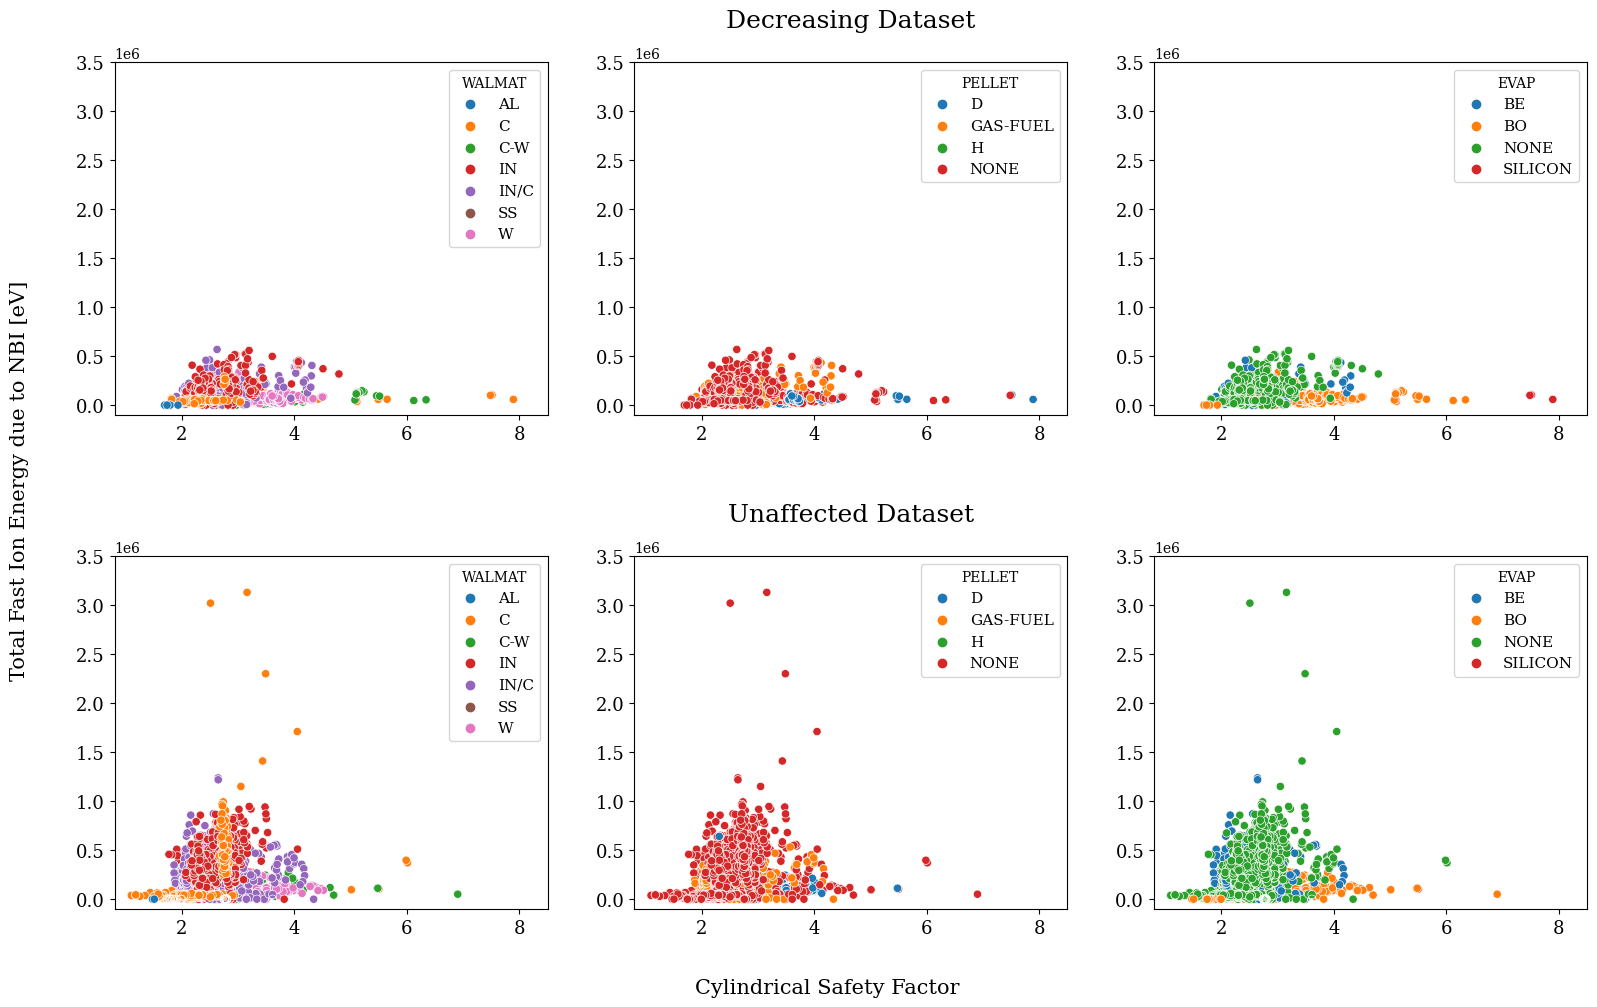

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(19, 11))
fig.subplots_adjust(hspace=0.4)


cat_params = ["WALMAT", "PELLET", "EVAP"] # These are key cat values for prediction according to RF
xy__params = ["QCYL5", "WFFORM"]
x___label  = "Cylindrical Safety Factor" 
y___label  = "Total Fast Ion Energy due to NBI [eV]"


data_ = data1.copy()
for i in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[i], hue_order=HUE_ORDER[cat_params[i]], ax=axs[0,i])
data_ = data2.copy()
for j in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[j], hue_order=HUE_ORDER[cat_params[j]], ax=axs[1,j])

for i, ax in enumerate(axs.flatten()):
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_ylim(-0.1e6, 3.5e6)   # REMEMBER TO MODIFY WHEN WORKING WITH DIFF PARAMS
    ax.set_xlim(0.8, 8.5)   # REMEMBER TO MODIFY WHEN WORKING WITH DIFF PARAMS
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(fontsize=11, title=(cat_params*2)[i])
    
# Add text label for x-labels at the bottom of the plot
fig.text(0.5, 0.03, x___label, 
         ha='center', va='bottom', fontsize=15
        )

# Add text label for y-labels at the left of the plot
fig.text(0.07, 0.5, y___label, 
         ha='left', va='center', rotation='vertical', fontsize=15
        )

axs[0, 1].set_title("Decreasing Dataset\n", fontsize=18)
axs[1, 1].set_title("Unaffected Dataset\n", fontsize=18);

#plt.savefig(fig_path+"P3_RF_WWFORM-TAUBOHM.pdf", format="pdf", dpi=800, bbox_inches='tight');

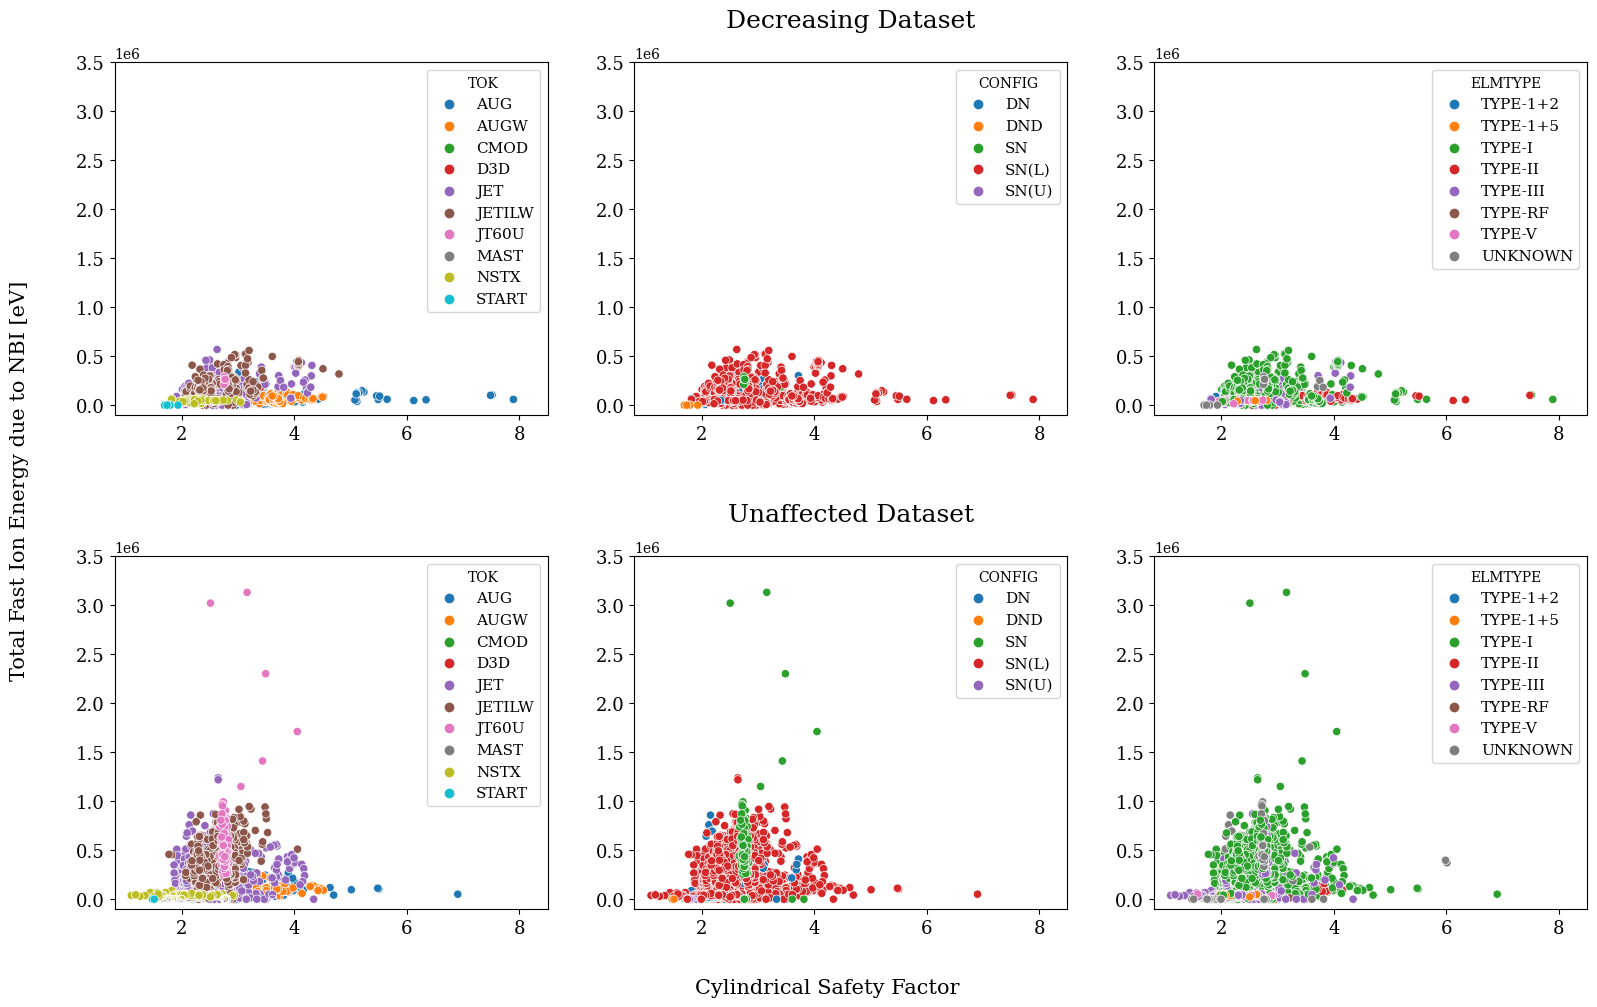

In [30]:
fig, axs = plt.subplots(2, 3, figsize=(19, 11))
fig.subplots_adjust(hspace=0.4)


cat_params = ["TOK", "CONFIG", "ELMTYPE"] 
xy__params = ["QCYL5", "WFFORM"]
x___label  = "Cylindrical Safety Factor" 
y___label  = "Total Fast Ion Energy due to NBI [eV]"


data_ = data1.copy()
for i in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[i], hue_order=HUE_ORDER[cat_params[i]], ax=axs[0,i])
data_ = data2.copy()
for j in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[j], hue_order=HUE_ORDER[cat_params[j]], ax=axs[1,j])

for i, ax in enumerate(axs.flatten()):
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_ylim(-0.1e6, 3.5e6)   # REMEMBER TO MODIFY WHEN WORKING WITH DIFF PARAMS
    ax.set_xlim(0.8, 8.5)   # REMEMBER TO MODIFY WHEN WORKING WITH DIFF PARAMS
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(fontsize=11, title=(cat_params*2)[i])
    
# Add text label for x-labels at the bottom of the plot
fig.text(0.5, 0.03, x___label, 
         ha='center', va='bottom', fontsize=15
        )

# Add text label for y-labels at the left of the plot
fig.text(0.07, 0.5, y___label, 
         ha='left', va='center', rotation='vertical', fontsize=15
        )

axs[0, 1].set_title("Decreasing Dataset\n", fontsize=18)
axs[1, 1].set_title("Unaffected Dataset\n", fontsize=18);

#plt.savefig(fig_path+"P3_RF_WWFORM-TAUBOHM.pdf", format="pdf", dpi=800, bbox_inches='tight');

---
---


# <center>`ENBI` VS `QCYL5`</center>

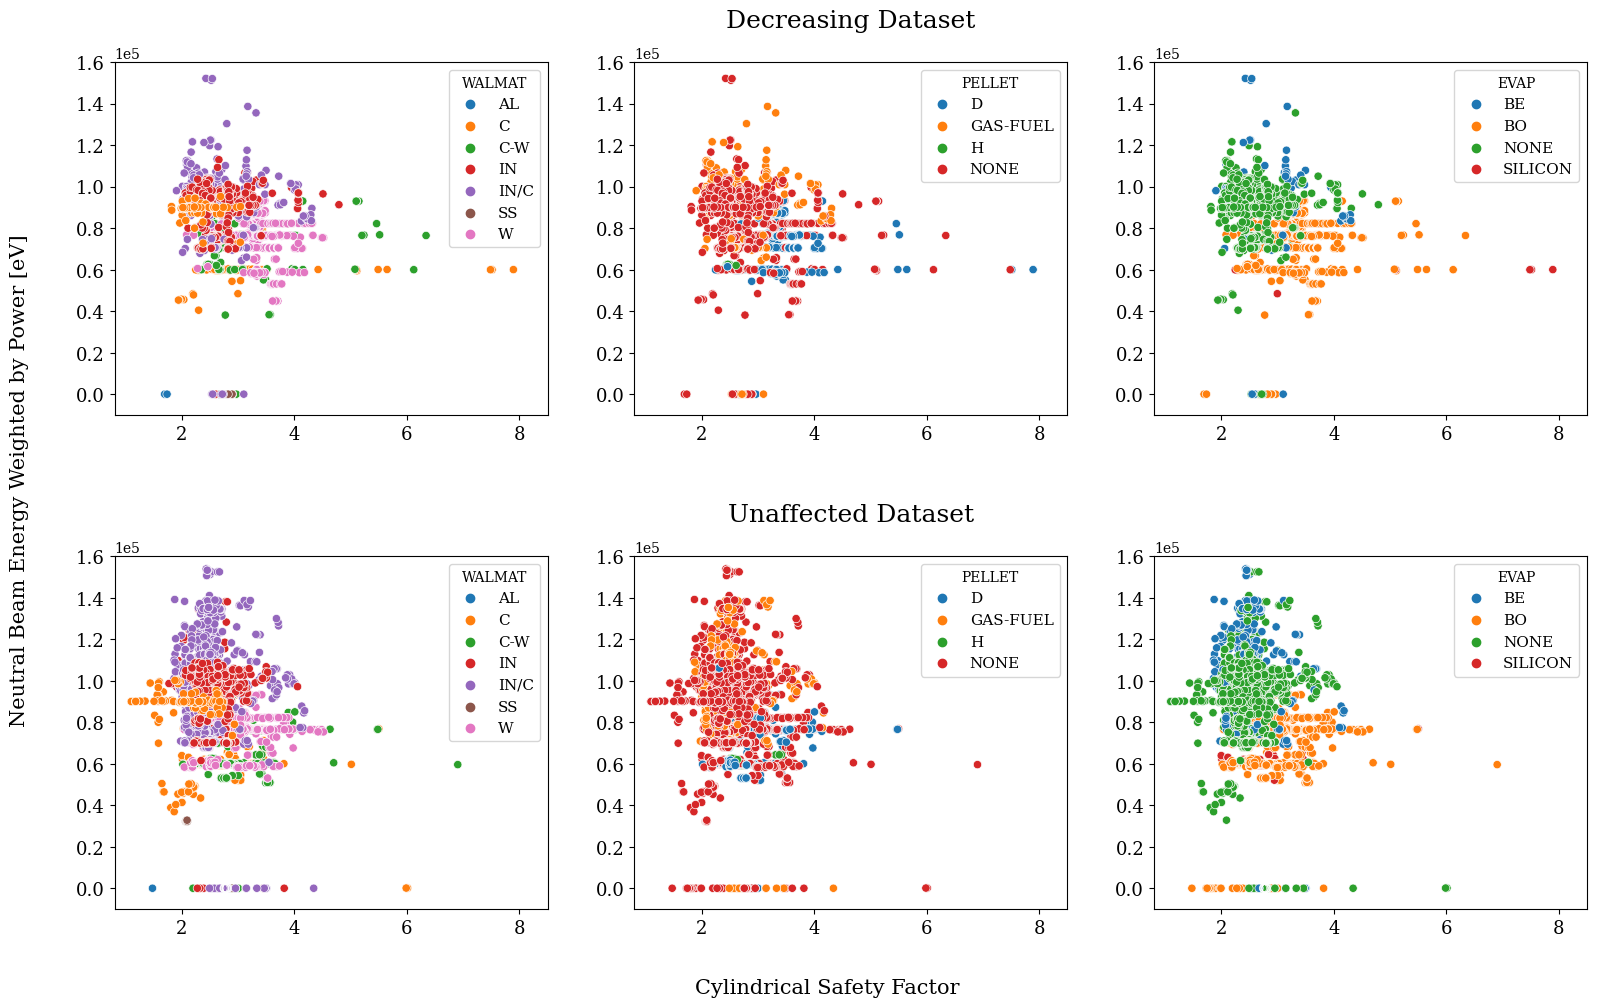

In [34]:
fig, axs = plt.subplots(2, 3, figsize=(19, 11))
fig.subplots_adjust(hspace=0.4)


cat_params = ["WALMAT", "PELLET", "EVAP"] # These are key cat values for prediction according to RF
xy__params = ["QCYL5", "ENBI"]
x___label  = "Cylindrical Safety Factor" 
y___label  = "Neutral Beam Energy Weighted by Power [eV]"


data_ = data1.copy()
for i in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[i], hue_order=HUE_ORDER[cat_params[i]], ax=axs[0,i])
data_ = data2.copy()
for j in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[j], hue_order=HUE_ORDER[cat_params[j]], ax=axs[1,j])

for i, ax in enumerate(axs.flatten()):
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_ylim(-0.1e5, 1.6e5)   # REMEMBER TO MODIFY WHEN WORKING WITH DIFF PARAMS
    ax.set_xlim(0.8, 8.5)   # REMEMBER TO MODIFY WHEN WORKING WITH DIFF PARAMS
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(fontsize=11, title=(cat_params*2)[i])
    
# Add text label for x-labels at the bottom of the plot
fig.text(0.5, 0.03, x___label, 
         ha='center', va='bottom', fontsize=15
        )

# Add text label for y-labels at the left of the plot
fig.text(0.07, 0.5, y___label, 
         ha='left', va='center', rotation='vertical', fontsize=15
        )

axs[0, 1].set_title("Decreasing Dataset\n", fontsize=18)
axs[1, 1].set_title("Unaffected Dataset\n", fontsize=18);

#plt.savefig(fig_path+"P3_RF_WWFORM-TAUBOHM.pdf", format="pdf", dpi=800, bbox_inches='tight');

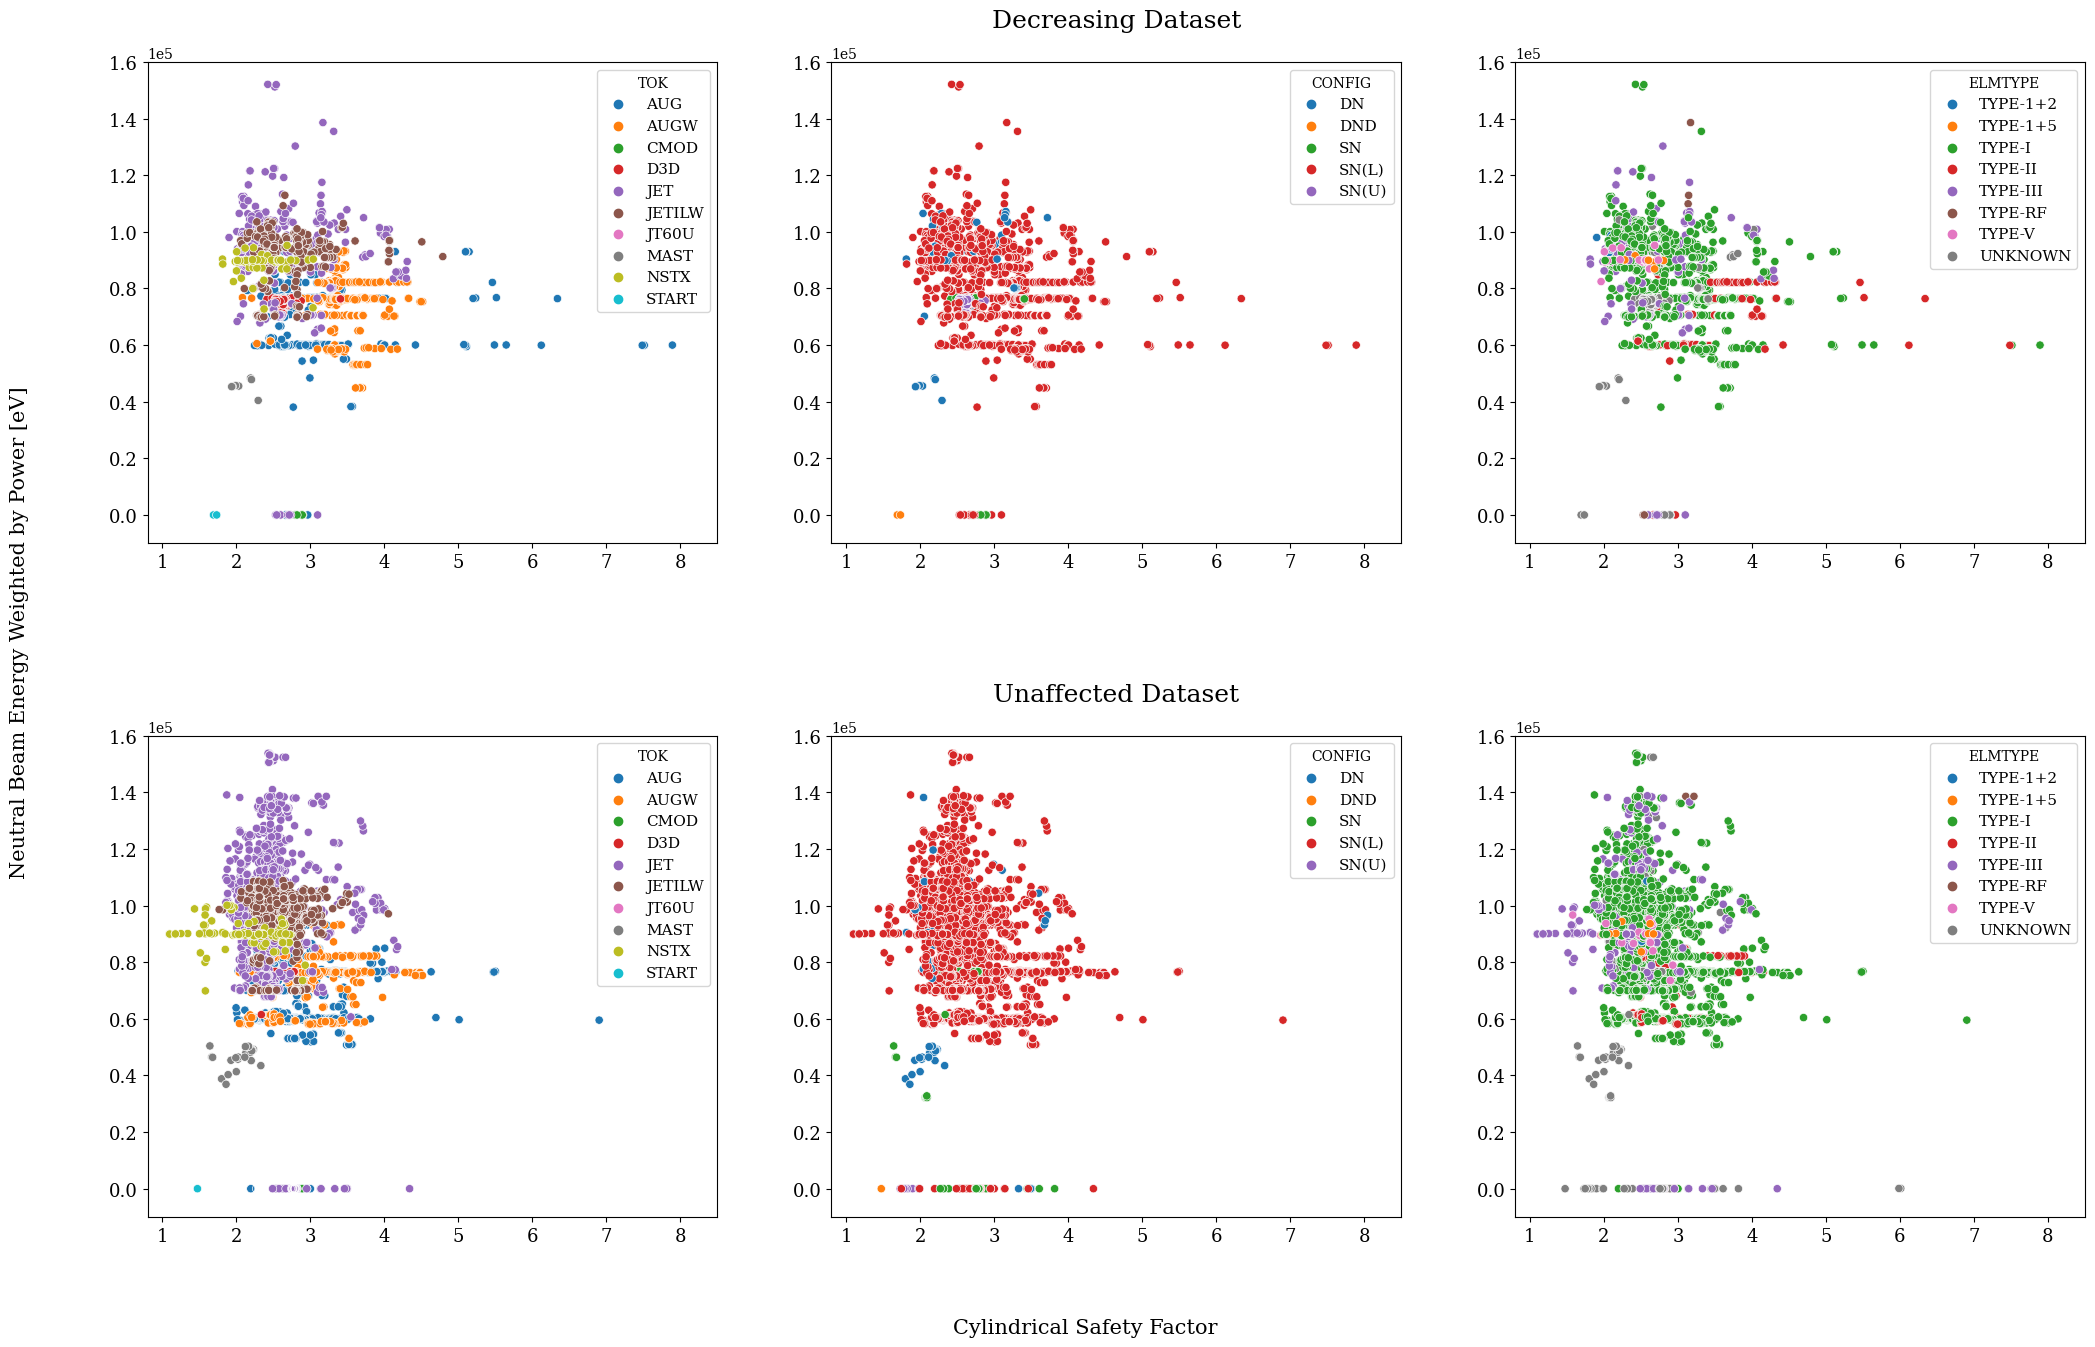

In [37]:
fig, axs = plt.subplots(2, 3, figsize=(25, 15))
fig.subplots_adjust(hspace=0.4)


cat_params = ["TOK", "CONFIG", "ELMTYPE"] 
xy__params = ["QCYL5", "ENBI"]
x___label  = "Cylindrical Safety Factor" 
y___label  = "Neutral Beam Energy Weighted by Power [eV]"


data_ = data1.copy()
for i in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[i], hue_order=HUE_ORDER[cat_params[i]], ax=axs[0,i])
data_ = data2.copy()
for j in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[j], hue_order=HUE_ORDER[cat_params[j]], ax=axs[1,j])

for i, ax in enumerate(axs.flatten()):
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_ylim(-0.1e5, 1.6e5)   # REMEMBER TO MODIFY WHEN WORKING WITH DIFF PARAMS
    ax.set_xlim(0.8, 8.5)   # REMEMBER TO MODIFY WHEN WORKING WITH DIFF PARAMS
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(fontsize=11, title=(cat_params*2)[i])
    
# Add text label for x-labels at the bottom of the plot
fig.text(0.5, 0.03, x___label, 
         ha='center', va='bottom', fontsize=15
        )

# Add text label for y-labels at the left of the plot
fig.text(0.07, 0.5, y___label, 
         ha='left', va='center', rotation='vertical', fontsize=15
        )

axs[0, 1].set_title("Decreasing Dataset\n", fontsize=18)
axs[1, 1].set_title("Unaffected Dataset\n", fontsize=18);

#plt.savefig(fig_path+"P3_RF_WWFORM-TAUBOHM.pdf", format="pdf", dpi=800, bbox_inches='tight');

---
---


# <center>`WMHD` VS `PRAD`</center>

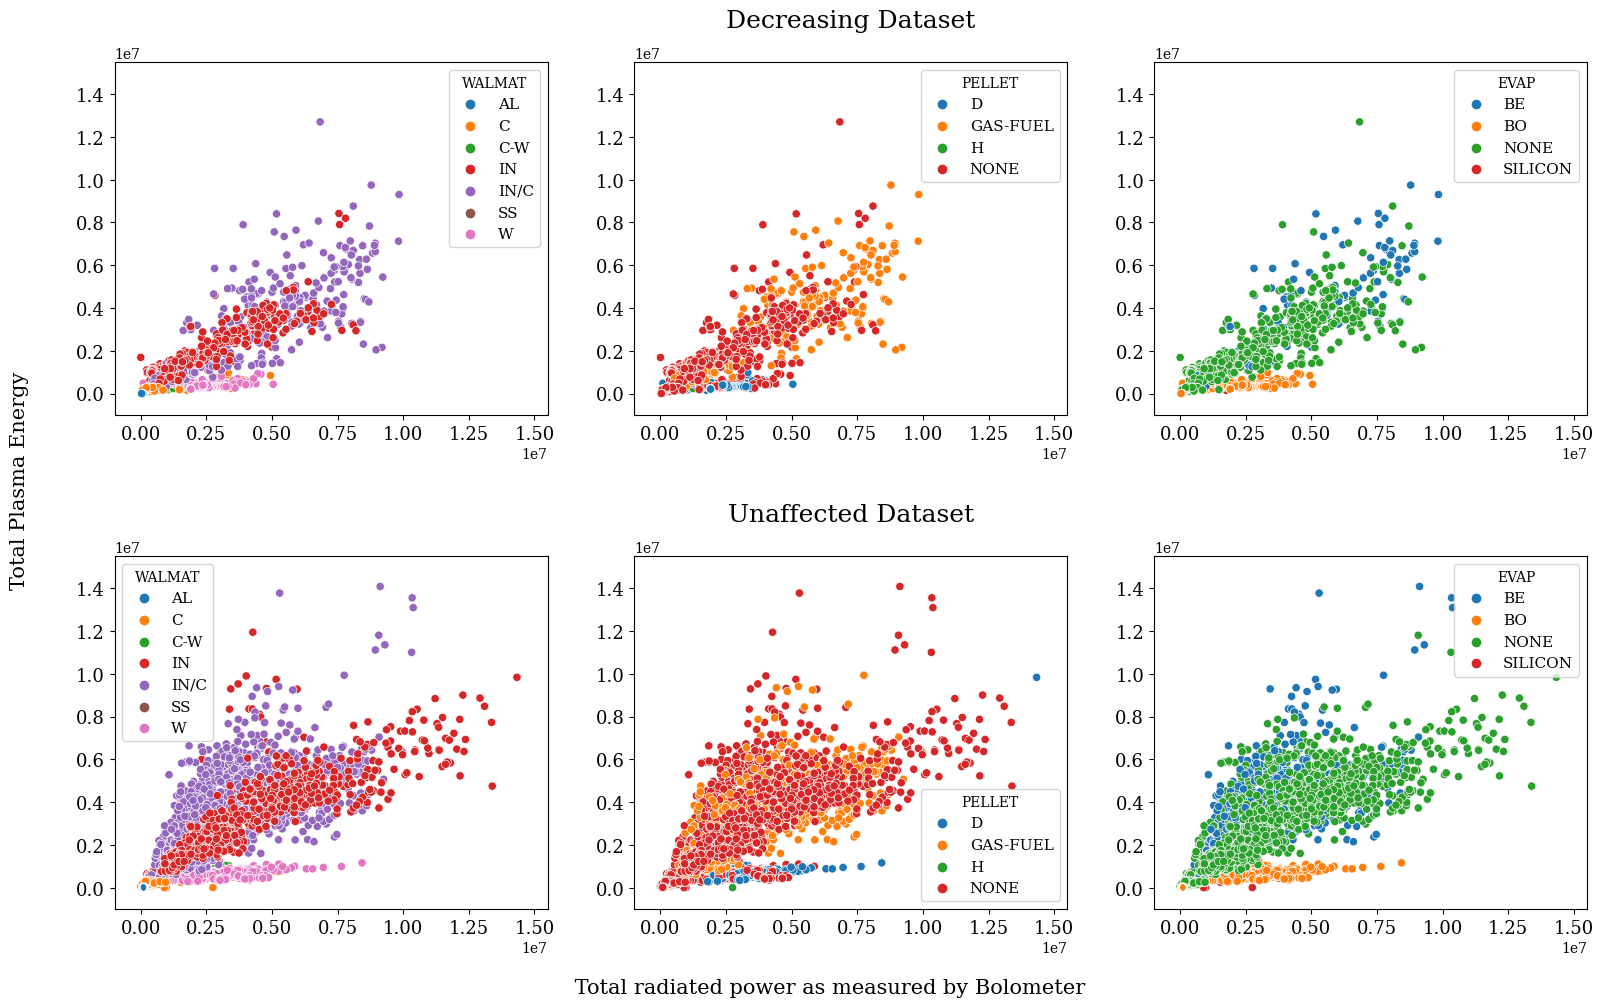

In [44]:
fig, axs = plt.subplots(2, 3, figsize=(19, 11))
fig.subplots_adjust(hspace=0.4)

### Plot Params ---------------------------------------------------------------------------------------
### ---------------------------------------------------------------------------------------------------
cat_params = ["WALMAT", "PELLET", "EVAP"] # These are key cat values for prediction according to RF
xy__params = ["PRAD", "WMHD"]
x___label  = "Total radiated power as measured by Bolometer [W]" 
y___label  = "Total Plasma Energy [W]"
x__minmax  = (None, None)
y__minmax  = (-0.1e7, 1.55e7)

fig_name__ = f"RF_2Groups_{xy__params}__{cat_params}.pdf"
fig_format = fig_name__.split('.')[-1]
### ---------------------------------------------------------------------------------------------------
### ---------------------------------------------------------------------------------------------------


data_ = data1.copy()
for i in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[i], hue_order=HUE_ORDER[cat_params[i]], ax=axs[0,i])
data_ = data2.copy()
for j in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[j], hue_order=HUE_ORDER[cat_params[j]], ax=axs[1,j])

for i, ax in enumerate(axs.flatten()):
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_ylim(y__minmax[0],y__minmax[1])
    ax.set_xlim(x__minmax[0],x__minmax[1])  
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(fontsize=11, title=(cat_params*2)[i])
    
# Add text label for x-labels at the bottom of the plot
fig.text(0.5, 0.03, x___label, 
         ha='center', va='bottom', fontsize=15
        )

# Add text label for y-labels at the left of the plot
fig.text(0.07, 0.5, y___label, 
         ha='left', va='center', rotation='vertical', fontsize=15
        )

axs[0, 1].set_title("Decreasing Dataset\n", fontsize=18)
axs[1, 1].set_title("Unaffected Dataset\n", fontsize=18);

#plt.savefig(fig_path+fig_name__, format=fig_format, dpi=800, bbox_inches='tight');

* In some cases, high TRP values can indicate increased radiation losses from the plasma, which can have negative effects on plasma performance and energy confinement. This can result in reduced plasma temperature and density, and decreased overall plasma energy content.
* High TRP values can also indicate increased impurity content in the plasma, as impurities can significantly contribute to radiation losses.
* In certain scenarios, high TRP values may be desirable or intentionally created for specific experimental purposes. For example, in certain advanced tokamak scenarios, high TRP may be deliberately generated to control plasma pressure and avoid plasma disruptions. 

**It is clear that, the higher the total plasma energy, the higher the TRP.**

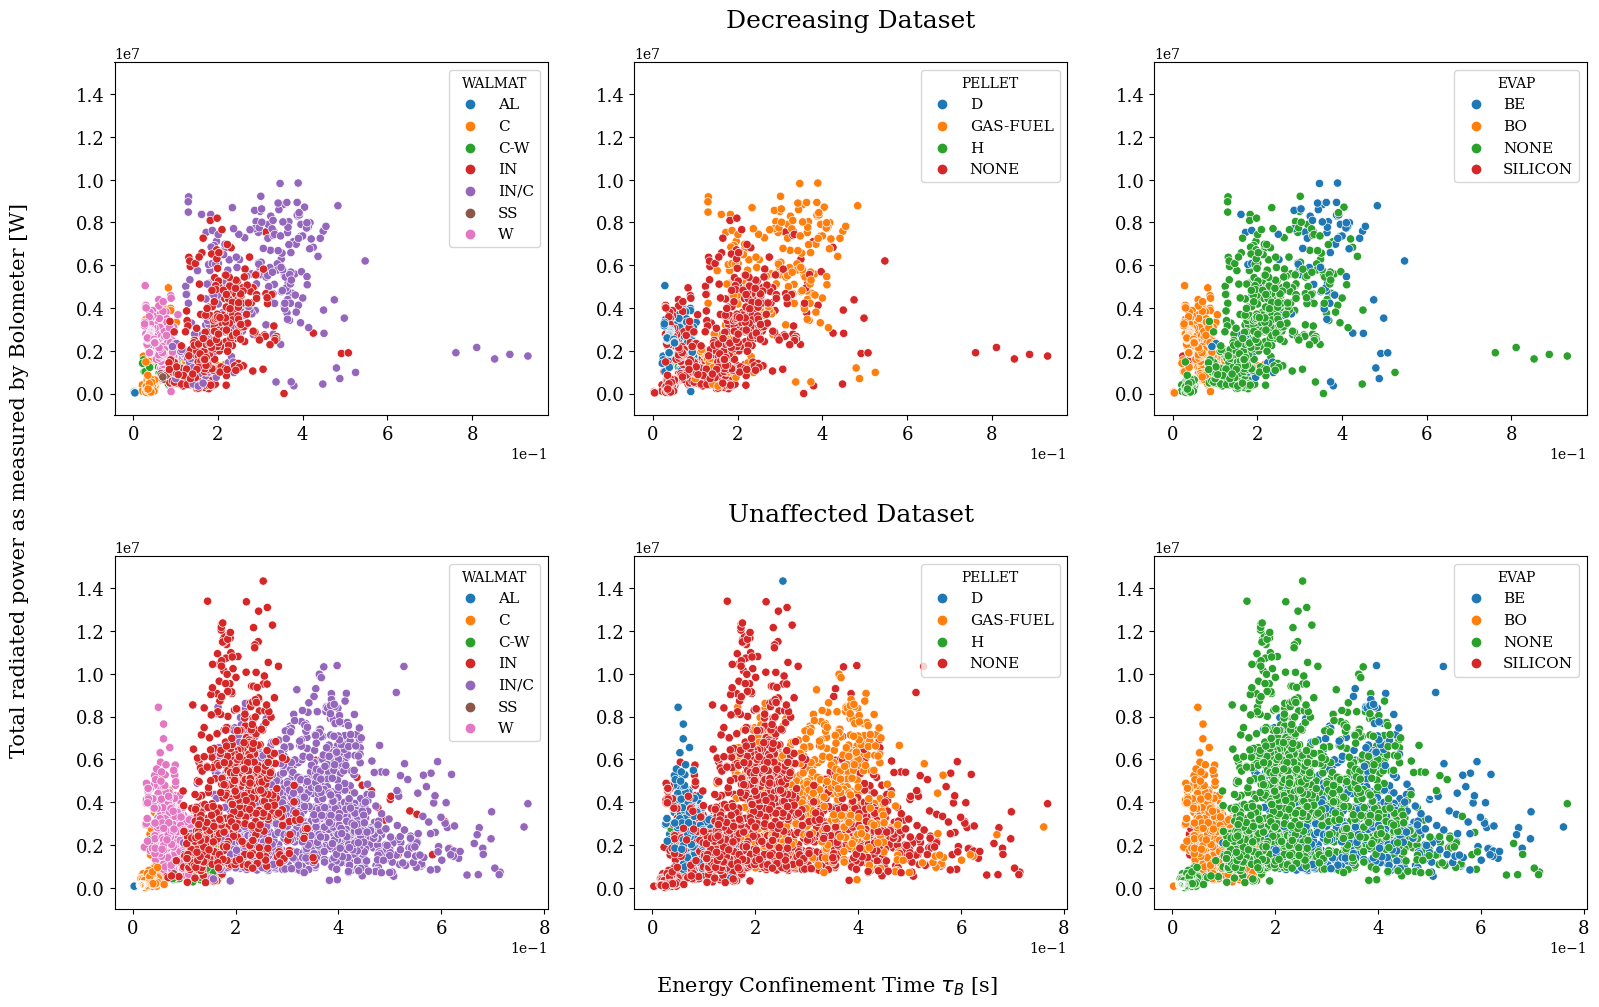

In [58]:
fig, axs = plt.subplots(2, 3, figsize=(19, 11))
fig.subplots_adjust(hspace=0.4)

### Plot Params ---------------------------------------------------------------------------------------
### ---------------------------------------------------------------------------------------------------
cat_params = ["WALMAT", "PELLET", "EVAP"] # These are key cat values for prediction according to RF
xy__params = ["TAUTH", "PRAD"]
x___label  = "Energy Confinement Time $\\tau_B$ [s]"
y___label  = "Total radiated power as measured by Bolometer [W]" 
x__minmax  = (None, None)
y__minmax  = (-0.1e7, 1.55e7)

fig_name__ = f"RF_2Groups_{xy__params}__{cat_params}.pdf"
fig_format = fig_name__.split('.')[-1]
### ---------------------------------------------------------------------------------------------------
### ---------------------------------------------------------------------------------------------------

data_ = data1.copy()
for i in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[i], hue_order=HUE_ORDER[cat_params[i]], ax=axs[0,i])
data_ = data2.copy()
for j in range(3):
    sns.scatterplot(data=data_, x=xy__params[0], y=xy__params[1], 
                    hue=cat_params[j], hue_order=HUE_ORDER[cat_params[j]], ax=axs[1,j])

for i, ax in enumerate(axs.flatten()):
    ax.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
    ax.tick_params(axis='x', labelsize=13)
    ax.tick_params(axis='y', labelsize=13)
    ax.set_ylim(y__minmax[0],y__minmax[1])
    ax.set_xlim(x__minmax[0],x__minmax[1])  
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.legend(fontsize=11, title=(cat_params*2)[i])
    
# Add text label for x-labels at the bottom of the plot
fig.text(0.5, 0.03, x___label, 
         ha='center', va='bottom', fontsize=15
        )

# Add text label for y-labels at the left of the plot
fig.text(0.07, 0.5, y___label, 
         ha='left', va='center', rotation='vertical', fontsize=15
        )

axs[0, 1].set_title("Decreasing Dataset\n", fontsize=18)
axs[1, 1].set_title("Unaffected Dataset\n", fontsize=18);

#plt.savefig(fig_path+fig_name__, format=fig_format, dpi=800, bbox_inches='tight');

Although group-1 has lower TRP registered, it doesn't achieve more confinmenet time as group-2 does. Suggesting that, group-2 might handle better impurities when terminating plasma. It is also possible to observe that `IN/C` `WALMAL` can handle more more TRP for higher confinement time. Furthermore, `Gas-Fuel` and no pellets make a notorious difference when dealing with TRL for high confinement time.  It is also clear that `BO` `EVAP` is not so effective when dealing with high TRP for achieving high confinement time; on the other hand, `BE` and no evaporation makes the difference. Remember that **EVAP = The evaporated material used to cover the inside of the vessel.**